
# מטלה-2 

#  ליאור בסל - 033536798 

#  חדד אליעזר - 022766364

# https://github.com/Lior1212avior/Machine-learning/upload	

In [112]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error , r2_score  # Import r2_score
import numpy as np
import matplotlib.pyplot as plt
import re

# טיפול בנתוני הקובץ - הוספת 2 תכונות חדשות כגון: ק"מ שנתי וכן ניקוד נוסף על הכנסת מס גבוה של תמונות , מילוי נתונים חסרים,משתנים קטגוריאליים, נרמול 

In [113]:
def prepare_data(file_path):
    df = pd.read_csv(file_path)   
    
    
# תיקון שמות המודל 
    results = []
    for index, row in df.iterrows():
        result = re.sub(re.escape(row['manufactor']), '', row['model'])
        results.append(result)

# Add the results to a new column in the DataFrame
    df['model'] = results

    
     #   ניקוד גבוה על העלאת מס תמונות גבוה - יצירת תכונה חדשה נוספת במודל 
    
    for index, row in df.iterrows():
        if row['Pic_num'] == 0:
            df.at[index, 'Pic_Score'] = 0
        elif row['Pic_num'] == 1:
            df.at[index, 'Pic_Score'] = 1
        elif row['Pic_num'] >= 2 and row['Pic_num'] < 5:
            df.at[index, 'Pic_Score'] = 2
        elif row['Pic_num'] >= 5 and row['Pic_num'] < 8:
            df.at[index, 'Pic_Score'] = 3
        elif row['Pic_num'] >= 8 and row['Pic_num'] < 15:
            df.at[index, 'Pic_Score'] = 4
     
        
    # מילוי ערכים חסרים
    df.fillna({
        'Hand': df['Hand'].mode()[0],
        'Gear': df['Gear'].mode()[0],
        'capacity_Engine': df['capacity_Engine'].mode()[0],
        'Prev_ownership': df['Prev_ownership'].mode()[0],
        'Curr_ownership': df['Curr_ownership'].mode()[0],
        'Area': df['Area'].mode()[0],
        'City': df['City'].mode()[0],
        'Pic_num': df['Pic_num'].mode()[0],
        'Description': '',
        'Color': df['Color'].mode()[0],
        'Km': df['Km'].mode()[0],
        'Test': df['Test'].mode()[0],
        'Pic_Score': df['Pic_Score'].mode()[0],
        'Supply_score': df['Supply_score'].mode()[0]
        
    }, inplace=True)
   
     
    # טיפול בעמודת התאריך
    df['Cre_date'] = pd.to_datetime(df['Cre_date'], format='%d/%m/%Y', errors='coerce')
    df['Repub_date'] = pd.to_datetime(df['Repub_date'], format='%d/%m/%Y', errors='coerce')


    # Alternatively, convert to a more interpretable numeric representation (e.g., day of the year)
    df['Cre_date'] = df['Cre_date'].dt.dayofyear  # Day of the year as int
    df['Repub_date'] = df['Repub_date'].dt.dayofyear  # Day of the year as int
       
     
    # המרת כל ערכי NaN במחרוזות למחרוזת ריקה
    categorical_columns = ['manufactor', 'model', 'Gear', 'Engine_type', 'Area', 'City', 'Color', 'Prev_ownership', 'Curr_ownership']
    for col in categorical_columns:
        df[col] = df[col].astype(str)
   
    # קידוד משתנים קטגוריאליים
    le = LabelEncoder()
    df['manufactor'] = le.fit_transform(df['manufactor'])
    df['model'] = le.fit_transform(df['model'])
    df['Gear'] = le.fit_transform(df['Gear'])
    df['Engine_type'] = le.fit_transform(df['Engine_type'])
    df['Area'] = le.fit_transform(df['Area'])
    df['City'] = le.fit_transform(df['City'])
    df['Color'] = le.fit_transform(df['Color'])
    df['Prev_ownership'] = le.fit_transform(df['Prev_ownership'])
    df['Curr_ownership'] = le.fit_transform(df['Curr_ownership'])
    df['Pic_Score'] = le.fit_transform(df['Pic_Score'])
   
    # הסרת פסיקים והמרת העמודות הערכיות לפורמט float     
    df['Km'] = df['Km'].str.replace(',', '').replace('None', '0').astype(float)
    df['capacity_Engine'] = df['capacity_Engine'].str.replace(',', '').astype(float)
    df['Year'].astype(int)
    
    # יצירת תכונות חדשות
    
    df['Car_age'] = 2024 - df['Year']
    df['Km_Per_year'] = df['Km'] - df['Car_age'] 
    
        
    # Drop the 'Description', 'Cre_date', and 'Repub_date' columns
    df.drop(columns=['Description', 'Cre_date', 'Repub_date'], inplace=True)
        
    
    # נרמול התכונות
    scaler = StandardScaler()
    numeric_features = ['Km', 'Supply_score','Prev_ownership', 'Curr_ownership' ]
    df[numeric_features] = scaler.fit_transform(df[numeric_features])
  
   
    return df

# הפעלת פונקצית_prepare_data  והוספת קוד עזר לבדיקת הנתונים בפועל

In [114]:
# מיקום קובץ מקור
input_data = 'c:\\Temp\\dataset.csv'
df = prepare_data(input_data)

# Ensure df is not None
if df is not None:
    # Save the processed data to a new CSV file
#     df.to_csv(utf8_file_path, index=False, encoding='utf-8-sig')
    print('Completed')
else:
    print('Error: Data processing failed')

Completed


# הגדרת התכונות והמחיר שיכנסו בפועל למודל 

#  בניית המודל בעזרת_ElasticNet 

# cross-validation

In [115]:
# Define features and target
X = df[['manufactor', 'model', 'Gear', 'Engine_type','Area', 'City', 'Km', 'capacity_Engine','Year','Supply_score','Km_Per_year','Pic_Score']]

y = df['Price']


# חלוקת הנתונים לסט אימון וסט בדיקה
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# בניית המודל והגדרת cross-validation
model = ElasticNet(alpha=0.5, l1_ratio=0.2 , random_state=42)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# אימון המודל על כל סט האימון
model.fit(X_train, y_train)

# חיזוי על סט הבדיקה
y_pred = model.predict(X_test)


# הערכת ביצועי המודל: 

# הערכת ביצוע מודל בעזרת_KFold Cross-Validation RMSE

# Fold Cross-Validation RMSE result: 17843.36131915945

# הערכת ביצוע המודל על הטסט בעזרת_RMSE

#  Predicted RMSE: 15769.42581511447

In [117]:
# ביצוע cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)

print(f'10-Fold Cross-Validation RMSE: {cv_rmse_scores.mean()}')

# ========================================
# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f'R-squared (R2): {r2}')

# ========================================
# Adjusted R-squared

n = len(y_test)
p = 2  # number of predictors

def calculate_adjusted_r2(y_true, y_pred, n, p):
    r2 = r2_score(y_test, y_pred)
    return 1 - ((1 - r2) * (n - 1)) / (n - p - 1)

print("Adjusted R-squared:", calculate_adjusted_r2(y_test, y_pred, n, p))

# ========================================
# הערכת המודל על סט הבדיקה
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'Predicted RMSE: {rmse}')


10-Fold Cross-Validation RMSE: 17843.36131915945
Adjusted R-squared: 0.48761380581890246
MAE: 12864.333811912444
MSE: 248674790.53839865
Predicted RMSE: 15769.42581511447


#  חמשת המאפיינים המשפיעים על החיזוי עם גודל וכיוון_Year,Gear,Engine_type,Supply_score,Manufactor  

In [118]:
# חמשת המאפיינים המשפיעים ביותר על החיזוי

feature_importance = pd.Series(model.coef_, index=X.columns)
top_5_features = feature_importance.abs().nlargest(5)
top_5_features = feature_importance[top_5_features.index]

print("Top 5 Features:")
print(top_5_features)

# הצגת השפעת המאפיינים
for feature, coef in top_5_features.items():
    if coef > 0:
        influence = 'Positive'
    else:
        influence = 'Negative'
    print(f'{feature}: {influence} ({coef})')


Top 5 Features:
Year            2805.727333
Gear           -1594.725635
Engine_type     1512.502241
Supply_score    -966.754050
manufactor      -420.604513
dtype: float64
Year: Positive (2805.727332748659)
Gear: Negative (-1594.7256353693083)
Engine_type: Positive (1512.5022410795732)
Supply_score: Negative (-966.7540501926026)
manufactor: Negative (-420.604513023741)


# הצגת המודל בעזרת Scatter 

      Actual     Predicted
1116   67000  59740.524642
1368   23000  43078.228525
422    69500  55794.624347
413    72000  64485.889338
451    69000  55176.155512


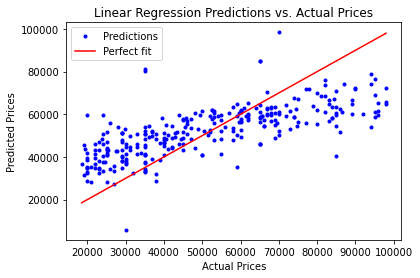

Compleated


In [119]:

# Show some predictions
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(predictions.head())

# ###################################################

# Scatter plot of actual vs. predicted values
# Gradient Descent Visualization with Linear Regression

# model = LinearRegression()
model.fit(X_train, y_train)

# Plotting gradient descent
fig, ax = plt.subplots()
ax.plot(y_test, model.predict(X_test), 'b.', label='Predictions')
ax.plot([min(y_test),max(y_test)], [min(y_test), max(y_test)], 'r-', label='Perfect fit')
ax.set_xlabel('Actual Prices')
ax.set_ylabel('Predicted Prices')
ax.legend()
ax.set_title('Linear Regression Predictions vs. Actual Prices')
plt.show()


y_pred = model.predict(X_test)
plt.show()

print('Compleated')



